In [1]:
%pylab inline
import gc
import numpy as np
import astropy.io.fits as pyfits
import numpy.lib.recfunctions as rfn

import fpfsBase
import imgSimutil

pltDir='plot/redshift/'

Populating the interactive namespace from numpy and matplotlib


In [4]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [5]:
cosmo252=   imgSimutil.cosmoHSTGal('252')
cosmo252.readHSTsample()
hscCat  =   cosmo252.catused
def estimate(slow=0.15,C=2000.,noiRev=True):
    vdir='outcome-var7em3'
    ngroup=16
    nsim=ngroup*250
    nic=3
    gest=np.zeros((nsim,nic))
    dest=np.zeros((nsim,nic))
    dss=0.01
    for igroup in range(ngroup):
        zUse=hscCat[10000*(igroup%8):10000*(igroup%8+1)]['zphot']
        for igf in range(250):
            ifield=igroup*250+igf
            fname1=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
            moments1=pyfits.getdata(fname1)
            elli1=fpfsM2E(moments1,C,rev=noiRev)
            mask1A=elli1['fpfs_s0']>slow
            
            fname2=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
            moments2=pyfits.getdata(fname2)
            elli2=fpfsM2E(moments2,C,rev=noiRev)
            mask2A=elli2['fpfs_s0']>slow
            for ic in range(nic):
                zlow=0.6*(ic)
                zhigh=0.6*(1+ic)
                maskZ= (zUse>zlow)&(zUse<=zhigh)
                eTmp=elli1[maskZ&mask1A]
                mskTmp=(eTmp['fpfs_s0']<=slow+dss)
                RS=-np.sum(eTmp[mskTmp]['fpfs_RS']/dss)
                g1p=np.sum(eTmp['fpfs_e1'])
                downp=(np.sum(eTmp['fpfs_RE'])+RS)
                del eTmp,mskTmp
                gc.collect()

                eTmp=elli2[maskZ&mask2A]
                mskTmp=(eTmp['fpfs_s0']<=slow+dss)
                RS=-np.sum(eTmp[mskTmp]['fpfs_RS']/dss)
                g1m=np.sum(eTmp['fpfs_e1'])
                downm=np.sum(eTmp['fpfs_RE'])+RS
                del eTmp,mskTmp,maskZ
                gc.collect()
                gest[ifield,ic]=(g1m-g1p)
                dest[ifield,ic]=(downm+downp)/2.
            del elli1,elli2,mask1A,mask2A,moments1,moments2
            gc.collect
    return np.average(gest,axis=0)/0.04/np.average(dest,axis=0)-1,np.std(gest,axis=0)/0.04/np.sqrt(nsim)/np.average(dest,axis=0)

def fpfsM2E(moments,const=2000.,mcalib=0.,rev=False):
    """
    # Estimate FPFS ellipticities from fpfs moments

    Parameters:
    -----------
    moments:    input FPFS moments     [float array]
    const:      the weighting Constant [float]
    mcalib:     multiplicative bias [float array]

    Returns:
    -------------
    out :       an array of FPFS ellipticities,
                FPFS ellipticity response,
                FPFS flux ratio, and FPFS selection response
    """
    #Get weight
    weight  =   1./(moments['fpfs_M00']+const)
    #Ellipticity
    e1      =   moments['fpfs_M22c']*weight
    e2      =   moments['fpfs_M22s']*weight
    e1sq    =   e1*e1
    e2sq    =   e2*e2
    #FPFS flux ratio
    s0      =   moments['fpfs_M00']*weight
    s4      =   moments['fpfs_M40']*weight
    #FPFS sel Respose (part1)
    e1sqS0  =   e1sq*s0
    e2sqS0  =   e2sq*s0

    if rev:
        assert 'fpfs_N00N00' in moments.dtype.names
        assert 'fpfs_N00N22c' in moments.dtype.names
        assert 'fpfs_N00N22s' in moments.dtype.names
        assert 'fpfs_N00N40' in moments.dtype.names
        ratio=  moments['fpfs_N00N00']*weight**2.
        weight= weight/(1+ratio)
        ratio=  moments['fpfs_N00N00']*weight**2.
        
        e1  =   (e1+moments['fpfs_N00N22c']\
                *weight**2.)/(1+ratio)
        e2  =   (e2+moments['fpfs_N00N22s']\
                *weight**2.)/(1+ratio)
        e1sq=   (e1sq-moments['fpfs_N22cN22c']*weight**2.\
                +4.*e1*moments['fpfs_N00N22c']*weight**2.)\
                /(1.+3*ratio)
        e2sq=   (e2sq-moments['fpfs_N22sN22s']*weight**2.\
                +4.*e2*moments['fpfs_N00N22s']*weight**2.)\
                /(1.+3*ratio)
        s0  =   (s0+moments['fpfs_N00N00']\
                *weight**2.)/(1+ratio)
        s4  =   (s4+moments['fpfs_N00N40']\
                *weight**2.)/(1+ratio)
        
        e1sqS0= (e1sqS0+3.*e1sq*moments['fpfs_N00N00']*weight**2.\
                -s0*moments['fpfs_N22cN22c']*weight**2.\
                -2*e1*(1-3*s0)*moments['fpfs_N00N22c']*weight**2.\
                 )/(1+6.*ratio)
        e2sqS0= (e2sqS0+3.*e2sq*moments['fpfs_N00N00']*weight**2.\
                -s0*moments['fpfs_N22sN22s']*weight**2.\
                -2*e2*(1-3*s0)*moments['fpfs_N00N22s']*weight**2.\
                 )/(1+6.*ratio)
        
    eSq     =   e1sq+e2sq
    eSqS0   =   e1sqS0+e2sqS0
    #Response factor
    RE      =   1./np.sqrt(2.)*(s0-s4+e1sq+e2sq)
    types   =   [('fpfs_e1','>f8'),('fpfs_e2','>f8'),('fpfs_RE','>f8'),\
                ('fpfs_s0','>f8'), ('fpfs_eSquare','>f8'), ('fpfs_RS','>f8')]
    ellDat  =   np.array(np.zeros(moments.size),dtype=types)
    ellDat['fpfs_e1']   =   e1
    ellDat['fpfs_e2']   =   e2
    ellDat['fpfs_RE']   =   RE
    ellDat['fpfs_s0']   =   s0
    ellDat['fpfs_eSquare']  =   eSq
    ellDat['fpfs_RS']   =   (eSq-eSqS0)/np.sqrt(2.)
    return ellDat

In [6]:
CBase2=4000.
mT,merrT=estimate(slow=0.15,C=CBase2,noiRev=True)
mF,merrF=estimate(slow=-0.1,C=CBase2,noiRev=True)

In [5]:
mT

array([-0.00142435, -0.00160092, -0.00487563])

In [6]:
mF

array([-0.00062008, -0.00025128, -0.00103846])

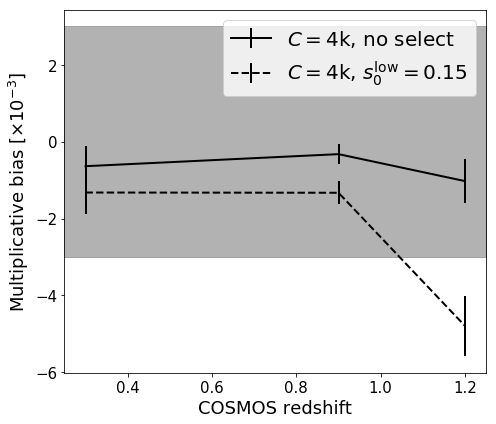

In [7]:
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
zlist=np.array([0.3,0.9,1.2])
ax.errorbar(zlist,mF*1000,merrF*1000,fmt='-',c='black',linewidth=2,label=r'$C=4$k, no select')
ax.errorbar(zlist,mT*1000,merrT*1000,fmt='--',c='black',linewidth=2,label=r'$C=4$k, $s_0^{\rm low}=0.15$')
ax.fill_between(np.linspace(0.25,1.25,100),-3e0*np.ones(100),3e0*np.ones(100),color='gray',alpha=0.6)
ax.set_xlim(0.25,1.25)
ax.set_xlabel(r'COSMOS redshift')
ax.set_ylabel(r'Multiplicative bias [$\times 10^{-3}$]')
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(pltDir,'redshift_depend.png'))
fig.savefig(os.path.join(pltDir,'redshift_depend.pdf'))

/lustre/work/xiangchong.li/ana/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


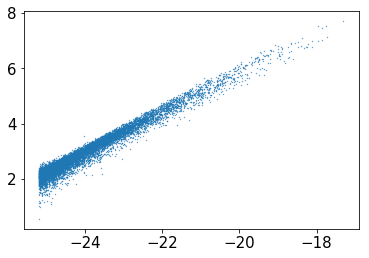

In [29]:
if False:
    fname=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(0,0))
    moments=pyfits.getdata(fname)
    plt.scatter(-hscCat[:10000]['mag_auto'],log10(moments['fpfs_M00']),s=0.1)

(array([2.6240e+03, 8.0590e+03, 8.6680e+03, 9.4150e+03, 1.1206e+04,
        8.8070e+03, 7.9740e+03, 5.0330e+03, 3.6930e+03, 2.4640e+03,
        2.4350e+03, 1.8240e+03, 1.4210e+03, 1.2740e+03, 1.5070e+03,
        9.7000e+02, 6.6300e+02, 6.1600e+02, 4.5000e+02, 2.9700e+02,
        1.6200e+02, 1.7900e+02, 6.8000e+01, 5.5000e+01, 4.7000e+01,
        4.2000e+01, 2.3000e+01, 1.3000e+01, 6.0000e+00, 5.0000e+00]),
 array([4.99999989e-03, 1.85113335e-01, 3.65226670e-01, 5.45340006e-01,
        7.25453341e-01, 9.05566676e-01, 1.08568001e+00, 1.26579335e+00,
        1.44590668e+00, 1.62602002e+00, 1.80613335e+00, 1.98624669e+00,
        2.16636002e+00, 2.34647336e+00, 2.52658669e+00, 2.70670003e+00,
        2.88681336e+00, 3.06692670e+00, 3.24704004e+00, 3.42715337e+00,
        3.60726671e+00, 3.78738004e+00, 3.96749338e+00, 4.14760671e+00,
        4.32772005e+00, 4.50783338e+00, 4.68794672e+00, 4.86806005e+00,
        5.04817339e+00, 5.22828672e+00, 5.40840006e+00]),
 <a list of 30 Patch objects

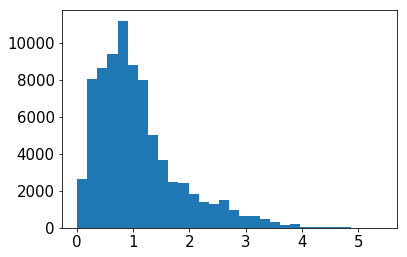

In [20]:
if False:
    plt.hist(hscCat['zphot'][:80000],bins=30)